---

CARGA DE LIBRERÍAS Y DATOS

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, classification_report
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import chi2
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import FunctionTransformer, RobustScaler
from sklearn.metrics import mean_squared_error

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Cupido_IA_project/train.csv')

In [ ]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,label
0,51.0,1.0,1.0,125.0,213.0,0.0,2.0,125.0,1.0,1.4,1.0,1.0,3.0,0
1,54.0,1.0,3.0,120.0,237.0,0.0,0.0,150.0,1.0,1.5,-9.0,-9.0,7.0,2
2,63.0,1.0,4.0,140,0,?,2.0,149,0,2,1,?,?,2
3,52.0,0.0,2.0,140.0,-9.0,0.0,0.0,140.0,0.0,0.0,-9.0,-9.0,-9.0,0
4,55.0,1.0,4.0,140.0,217.0,0.0,0.0,111.0,1.0,5.6,3.0,0.0,7.0,3


---

CAMBIAR FORMATO Y NOMBRE

---

In [ ]:
cols_to_int = ['age', 'sex', 'cp', 'restecg']
cols_continuas = ["edad",
    "tension_en_descanso",
    "colesterol",
    "latidos_por_minuto",
    "cambio_linea_corazon_ejercicio"]
for col in cols_to_int:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df[col].astype('Int64')

object_cols = df.select_dtypes(include=['object']).columns
for col in object_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.rename(columns={"age": "edad",
    "sex": "sexo",
    "cp": "tipo_dolor_pecho",
    "trestbps": "tension_en_descanso",
    "chol": "colesterol",
    "fbs": "azucar",
    "restecg": "electro_en_descanso",
    "thalach": "latidos_por_minuto",
    "exang": "dolor_pecho_con_ejercicio",
    "oldpeak": "cambio_linea_corazon_ejercicio",
    "slope": "forma_linea_corazon_ejercicio",
    "ca": "num_venas_grandes",
    "thal": "estado_corazon_thal"})


--- Cantidad de Nulos ---
edad                                0
sexo                                0
tipo_dolor_pecho                    0
tension_en_descanso                47
colesterol                          5
azucar                             58
electro_en_descanso                 0
latidos_por_minuto                 44
dolor_pecho_con_ejercicio          44
cambio_linea_corazon_ejercicio     49
forma_linea_corazon_ejercicio      95
num_venas_grandes                 249
estado_corazon_thal               169
label                               0
dtype: int64


## ANÁLISIS VALORES NULOS

---
SUSTITUCIÓN DE VALORES ERRÓNEOS POR NAs

---

In [ ]:
cols_con_errores = ['colesterol', 'azucar', 'forma_linea_corazon_ejercicio',
                    'num_venas_grandes', 'estado_corazon_thal']

# Reemplazamos -9 y -9.0 por NaN en todo el dataframe
df.replace([-9, -9.0], np.nan, inplace=True)

print("--- Cantidad de nulos reales tras limpieza ---")
print(df.isnull().sum().sort_values(ascending=False))
print("\n --- Cantidad de nulos reales en %")
print((df.isnull().sum() / len(df) * 100.3).round(2).sort_values(ascending=False))

--- Cantidad de nulos reales tras limpieza ---
num_venas_grandes                 479
estado_corazon_thal               379
forma_linea_corazon_ejercicio     247
azucar                             66
cambio_linea_corazon_ejercicio     49
tension_en_descanso                47
latidos_por_minuto                 44
dolor_pecho_con_ejercicio          44
colesterol                         21
edad                                0
tipo_dolor_pecho                    0
sexo                                0
electro_en_descanso                 0
label                               0
dtype: int64

 --- Cantidad de nulos reales en %
num_venas_grandes                 65.63
estado_corazon_thal               51.93
forma_linea_corazon_ejercicio     33.84
azucar                             9.04
cambio_linea_corazon_ejercicio     6.71
tension_en_descanso                6.44
latidos_por_minuto                 6.03
dolor_pecho_con_ejercicio          6.03
colesterol                         2.88
edad        

---

CORRELACIÓN Y CLUSTER ENTRE NAs, LABEL, EDAD Y SEXO

---

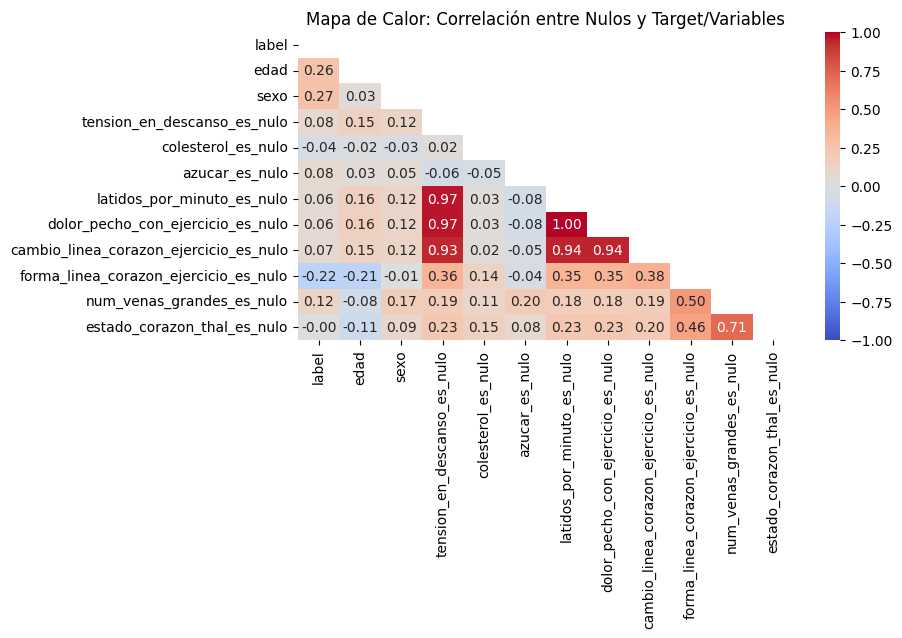

In [ ]:
df_shadow = df.isna().astype(int).add_suffix('_es_nulo')

# Unimos con el target, edad y sexo por si pueden tener relación
df_analysis = pd.concat([df[['label', 'edad', 'sexo']], df_shadow], axis=1)

# Filtramos columnas con nulos para limpiar el gráfico
cols_nulas = [col for col in df_shadow.columns if df_shadow[col].sum() > 0]
df_analysis = df_analysis[['label', 'edad', 'sexo'] + cols_nulas]

# MATRIZ DE CORRELACIÓN
plt.figure(figsize=(8, 4))
corr_matrix = df_analysis.corr()

# Máscara para el triángulo superior
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm',
            vmin=-1, vmax=1, fmt=".2f", mask=mask)

plt.title("Mapa de Calor: Correlación entre Nulos y Target/Variables")
plt.show()

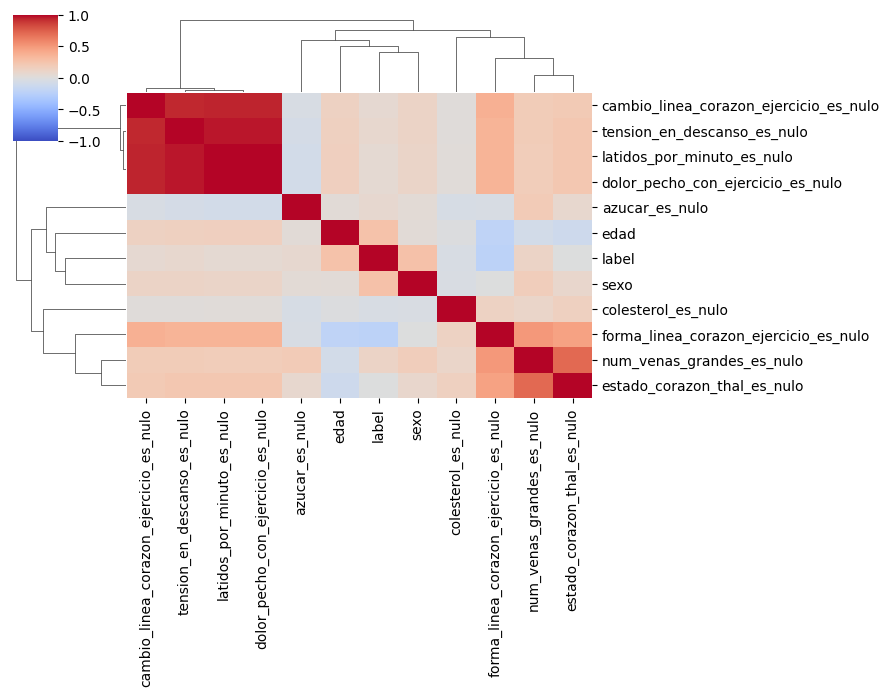

In [ ]:
sns.clustermap(corr_matrix, cmap="coolwarm", vmin=-1, vmax=1, annot=False,figsize=(9,7))

## Interpretación de Patrones de Nulidad

El análisis de agrupamiento jerárquico (dendrograma) y la matriz de correlación de nulos revelan tres estructuras que marcan la ausencia de información en el dataset. La nulidad, por tanto, no parece ser del todo aleatoria.

---

### 1. Bloque de "Prueba de Esfuerzo" (correlaciones > 0.9)

Se identifica un clúster primario extremadamente compacto formado por:

- `latidos_por_minuto`
- `dolor_pecho_con_ejercicio`
- `cambio_linea_corazon_ejercicio`

**Interpretación:**  
La ausencia de uno de estos datos implica casi siempre la ausencia de los otros. Esto sugiere un posible origen en el procedimiento, ya que si al paciente no se le realiza la prueba de esfuerzo físico, se pierden estas tres variables simultáneamente.  

---

### 2. Bloque de "Severidad/Invasivo"

Un segundo grupo se forma en torno a:

- `num_venas_grandes`
- `estado_corazon_thal`

Aunque su cohesión interna es menor (**0.73**), lo crítico es su correlación con la variable objetivo (`label`), que alcanza niveles de **0.30** y **0.18** respectivamente (tonos naranjas).

**Interpretación:**  
Aquí la ausencia es un predictor de riesgo en sí misma. La falta de información en pruebas más complejas está sesgada hacia pacientes con perfiles de salud distintos.

---

### 3. Variable Puente: `forma_linea_corazon_ejercicio`

Esta variable muestra un comportamiento **híbrido**.

El dendrograma la ubica cerca del bloque de severidad, pero el mapa de calor revela correlaciones significativas (~**0.65**) también con el bloque de prueba de esfuerzo.

**Interpretación:**  
Actúa como un nexo estructural: su ausencia puede deberse tanto a la falta como a la omisión de pruebas más complejas, compartiendo mecanismos de pérdida de ambos grupos.

---

---
TEST DE LITTLE MCAR

---

In [ ]:
# @title
def littles_mcar_test(data):
    """
    Realiza la prueba MCAR de Little.
    Input: DataFrame de Pandas con nulos.
    Output: Estadístico Chi-cuadrado y p-valor.
    """
    # Hacer copia y asegurar que trabajamos con numéricas y float64 para numpy compatibility
    df = data.copy().astype(float)

    # Obtenemos las variables con datos faltantes
    vars_with_missing = df.columns[df.isnull().any()].tolist()

    # Estimación de medias y covarianzas (EM algorithm simplificado)
    # Normalizamos los datos para el test
    from sklearn.experimental import enable_iterative_imputer
    from sklearn.impute import IterativeImputer

    # Usamos IterativeImputer (MICE) para estimar los parámetros de la distribución completa
    imp = IterativeImputer(max_iter=10, random_state=0)
    df_imputed = imp.fit_transform(df)

    # Medias y Covarianzas estimadas (Maximum Likelihood proxy)
    mean = df_imputed.mean(axis=0)
    cov = np.cov(df_imputed.T)

    # Parámetros para el test
    n = df.shape[0]
    k = df.shape[1]

    # Identificar patrones de nulidad (r)
    # Creamos un string binario para cada fila indicando qué falta
    mask = df.isnull()
    unique_patterns = mask.apply(lambda x: tuple(x), axis=1).unique()

    d2_stat = 0
    df_degrees = 0

    for pattern in unique_patterns:
        # Filtramos filas que coinciden con este patrón
        # pattern es una tupla de booleanos (True=Nulo)
        rows_in_pattern = mask.apply(lambda x: tuple(x) == pattern, axis=1)
        n_pattern = rows_in_pattern.sum()

        if n_pattern == 0: continue

        # Columnas observadas en este patrón (False en la máscara)
        observed_cols = [i for i, is_missing in enumerate(pattern) if not is_missing]
        missing_cols = [i for i, is_missing in enumerate(pattern) if is_missing]

        if len(observed_cols) == 0: continue # Todo nulo
        if len(observed_cols) == k: continue # Nada nulo

        # Subconjunto de datos observados
        observed_data = df.loc[rows_in_pattern].iloc[:, observed_cols]

        # Vector de medias observadas para este patrón
        y_obs_mean = observed_data.mean().values

        # Parte de la media global y covarianza correspondientes a cols observadas
        mu_j = mean[observed_cols]
        sigma_jj = cov[np.ix_(observed_cols, observed_cols)]

        # Diferencia entre media observada y media global estimada
        d = y_obs_mean - mu_j

        # Contribución al estadístico de Little (d^T * inv(Sigma) * d)
        try:
            d2 = n_pattern * (d.T @ np.linalg.solve(sigma_jj, d))
            d2_stat += d2
            df_degrees += len(observed_cols)
        except np.linalg.LinAlgError:
            continue # Si la matriz es singular, saltamos este patrón

    # Grados de libertad corregidos
    # Teoría: df = sum(k_j) - k
    # Pero una aproximación común es usar la distribución chi2 directamente con lo acumulado
    # El test original es complejo en grados de libertad, usamos la aproximación estándar

    p_value = 1 - chi2.cdf(d2_stat, df_degrees - k)

    return d2_stat, p_value

In [ ]:
cols_test = ['edad', 'tension_en_descanso', 'colesterol', 'azucar',
             'latidos_por_minuto', 'dolor_pecho_con_ejercicio',
             'cambio_linea_corazon_ejercicio', 'num_venas_grandes',
             'forma_linea_corazon_ejercicio']

chi_square, p_val = littles_mcar_test(df[cols_test])

print(f"Estadístico Chi-Cuadrado de Little: {chi_square:.4f}")
print(f"P-Valor: {p_val:.5f}")

if p_val < 0.05:
    print("RECHAZAMOS H0: Se acepta que los datos no son MCAR.")
else:
    print("NO rechazamos H0: Los datos podrían ser MCAR.")

Estadístico Chi-Cuadrado de Little: 564.0952
P-Valor: 0.00000
RECHAZAMOS H0: Se acepta que los datos no son MCAR.


## Validación Estadística: Prueba de MCAR de Little

Con un **p-valor < 0.05**, la imputación simple (mediana/moda) es un **error metodológico grave**.

---

### Resultados del Test de Little

- **Estadístico Chi-Cuadrado (χ²):** 564.09  
- **P-Valor:** < 0.05

**Interpretación:**  
Dado que el p-valor es inferior al nivel de significancia (0.05), se **rechaza  la hipótesis nula (H₀)** de que los datos faltan de forma totalmente aleatoria (MCAR).

---

### Conclusión Final del Diagnóstico

La evidencia **estadística** (Test de Little) y **visual** (Correlación con Target) confirma que el mecanismo de pérdida de datos es una mezcla de:

- **MAR:** dependencia entre pruebas médicas  
- **MNAR:** dependencia con la severidad del paciente

Esto valida la **estrategia de imputación híbrida**

### Nueva estrategia de imputación por variable

Para corregir la distorsión del espacio vectorial y mejorar el F1-Score de las clases intermedias, se implementa una **imputación híbrida** ajustada a la naturaleza del missing.

#### 🟥 Tratamiento MNAR (Venas / Thal)

- Generación de flags de nulidad (`_is_missing`) **antes** de imputar.
- Permite que el modelo aprenda que *“falta de dato = factor de riesgo”*.

#### 🟩 Tratamiento MAR (Resto de variables)

- Uso de **KNN Imputer (k = 5–10)** para reconstruir valores basándose en el perfil multivariante (p. ej., edad, sexo).
- Evita promedios planos y mantiene la geometría real del dato.

#### 🟨 Gestión de valores imposibles

Sustitución de la política “errores a 0” por:

- **Clipping ** (percentiles 1–99)

Esto preserva la patología extrema sin romper la escala numérica.